In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from tqdm import tqdm
import json
import os
import random
import math
import pickle
#import umap
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, confusion_matrix
from collections import deque

# import stellargraph as sg
# from stellargraph.mapper import FullBatchNodeGenerator
# from stellargraph.layer import GCN
import networkx as nx
import warnings
import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, constraints, regularizers
from tensorflow.keras.layers import Input, Layer, Lambda, Dropout, Reshape, Dense, Embedding,LeakyReLU, Maximum
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers, optimizers, losses, metrics, Model
import matplotlib.pyplot as plt
import seaborn as sns
# from stellargraph import StellarGraph
# from stellargraph.layer.gcn import GatherIndices
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

%matplotlib inline

In [6]:
dataFrame = pd.read_csv("/content/drive/MyDrive/GCN Classification/citation_sentiment_corpus.txt", sep = "	", header = None)
dataFrame.columns = ["Source_PaperID", "Target_PaperID", "Sentiment", "Citation_text"]
dataFrame.Sentiment = dataFrame.Sentiment.replace({"o": 1,"p": 2,"n": 0})

In [76]:
Source = dataFrame['Source_PaperID']
Target = dataFrame['Target_PaperID']
Sentiment = dataFrame['Sentiment']
G = nx.DiGraph(directed=True)
edges = pd.DataFrame(
    {
        "source": Source,
        "target": Target,
        "weight": Sentiment
    }
)
G = nx.from_pandas_edgelist(edges, edge_attr=True,create_using=nx.DiGraph())

In [77]:
leaderboard = {}
for x in G.nodes:
 leaderboard[x] = len(G[x])
s = pd.Series(leaderboard, name='Citations')
citation_counts = s.to_frame().sort_values('Citations', ascending=False)
citation_counts.value_counts()

Citations
1            1785
2             703
3             295
4             121
0              77
5              59
6              19
7               7
8               3
dtype: int64

In [78]:
citation_counts = citation_counts.reset_index(level=0)
citation_counts.columns = ['Node', 'Citations']
citation_counts.head()

,Node,Citations
0,W08-0306,8
1,N09-1058,8
2,D07-1070,8
3,N09-1049,7
4,P08-1068,7


In [79]:
zero_list = []
for i,j in zip(citation_counts['Node'], citation_counts['Citations']):
    if(j == 0):
      
        zero_list.append(i)
G.remove_nodes_from(zero_list)

In [80]:
print("Number of Nodes: ",G.number_of_nodes())
print("Number of Edges: ",G.number_of_edges())

Number of Nodes:  2992
Number of Edges:  1589


In [12]:
import os
all_data = []

for root,dirs,files in os.walk('.'):
    for file in files:
        if 'node2vec_embeddings.txt' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
all_data

#parse the data
nodes = []
node2vec_cc = []

for i,data in enumerate(all_data):
    elements = data.split(' ')
    node2vec_cc.append(elements[1:])
    nodes.append(elements[0])

In [13]:
node2vec_cc.pop(0)
nodes.pop(0)

'2992'

In [14]:
dataset = pd.DataFrame({'Node_id': nodes, 'embeddings': node2vec_cc}, columns=['Node_id', 'embeddings'])

In [15]:
df = dataFrame
labels = []
for i in nodes:
    for j,k in zip(df['Source_PaperID'],df['Sentiment']):
        if(i==j):
            labels.append(k)
            break

In [16]:
dataset["label"] = labels
dataset.label.value_counts()

1    2622
2     283
0      87
Name: label, dtype: int64

In [17]:
dataset.head()

,Node_id,embeddings,label
0,J97-3002,"[0.29475126, 0.29237565, 0.7402589, 0.5839545,...",1
1,N03-1017,"[-0.08274625, 0.59652436, 1.2793896, -0.135234...",1
2,W96-0213,"[0.08824804, -0.45551515, 0.14226653, -0.80273...",1
3,W02-1011,"[-0.8990309, -0.8870302, 0.717432, 0.24402909,...",1
4,P04-1035,"[-0.8811224, -1.5552723, 0.053557992, -0.05447...",1


In [18]:
column_names =[f"term_{idx}" for idx in range(128)]

In [19]:
node2vec_cc = pd.DataFrame(node2vec_cc, columns = column_names)

In [20]:
node2vec_cc.head()

,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,...,term_118,term_119,term_120,term_121,term_122,term_123,term_124,term_125,term_126,term_127
0,0.29475126,0.29237565,0.7402589,0.5839545,-0.5660996,-0.9100486,0.20029289,1.2977738,-0.116086334,0.26056316,...,-0.15942834,0.1429829,-0.07687346,-0.9226167,0.78992116,-0.84812886,0.49845138,0.38957667,-0.3366734,0.14115053
1,-0.08274625,0.59652436,1.2793896,-0.13523456,-0.29737115,-0.78901345,0.06501235,0.9344545,0.027245471,0.54895765,...,0.28383532,0.27552357,-0.088856906,-0.49268368,1.0905964,-0.65956247,-0.5185808,-0.29776338,-0.80166334,-0.30129644
2,0.08824804,-0.45551515,0.14226653,-0.80273306,1.0324552,-0.7385533,0.9176383,0.7226203,-0.89616984,1.2452774,...,0.24278162,-0.4781477,-0.6869531,0.84110194,0.27185586,0.67025656,-0.4129803,0.6605675,0.44515988,0.49230257
3,-0.8990309,-0.8870302,0.717432,0.24402909,-0.41392344,-0.68330127,-0.43823487,0.1426507,-0.9135517,-0.075670876,...,0.18539672,-0.3669928,-0.82656157,-0.0026124702,0.40108162,0.9708959,-0.65667415,-1.4535186,-0.87660235,-0.3967433
4,-0.8811224,-1.5552723,0.053557992,-0.05447238,-0.7145693,-0.44096208,-0.20929481,0.22100833,-1.2522765,-0.4542726,...,0.3774099,0.77015525,-0.3201643,0.39295188,-0.2822794,0.3054697,-0.4024803,-0.9890051,-1.0255593,-0.8270502


In [21]:
node2vec_cc["Node_id"] = dataset["Node_id"]
node2vec_cc["label"] = dataset["label"]

In [22]:
node2vec_cc.head()

,term_0,term_1,term_2,term_3,term_4,term_5,term_6,term_7,term_8,term_9,...,term_120,term_121,term_122,term_123,term_124,term_125,term_126,term_127,Node_id,label
0,0.29475126,0.29237565,0.7402589,0.5839545,-0.5660996,-0.9100486,0.20029289,1.2977738,-0.116086334,0.26056316,...,-0.07687346,-0.9226167,0.78992116,-0.84812886,0.49845138,0.38957667,-0.3366734,0.14115053,J97-3002,1
1,-0.08274625,0.59652436,1.2793896,-0.13523456,-0.29737115,-0.78901345,0.06501235,0.9344545,0.027245471,0.54895765,...,-0.088856906,-0.49268368,1.0905964,-0.65956247,-0.5185808,-0.29776338,-0.80166334,-0.30129644,N03-1017,1
2,0.08824804,-0.45551515,0.14226653,-0.80273306,1.0324552,-0.7385533,0.9176383,0.7226203,-0.89616984,1.2452774,...,-0.6869531,0.84110194,0.27185586,0.67025656,-0.4129803,0.6605675,0.44515988,0.49230257,W96-0213,1
3,-0.8990309,-0.8870302,0.717432,0.24402909,-0.41392344,-0.68330127,-0.43823487,0.1426507,-0.9135517,-0.075670876,...,-0.82656157,-0.0026124702,0.40108162,0.9708959,-0.65667415,-1.4535186,-0.87660235,-0.3967433,W02-1011,1
4,-0.8811224,-1.5552723,0.053557992,-0.05447238,-0.7145693,-0.44096208,-0.20929481,0.22100833,-1.2522765,-0.4542726,...,-0.3201643,0.39295188,-0.2822794,0.3054697,-0.4024803,-0.9890051,-1.0255593,-0.8270502,P04-1035,1


In [23]:
print(node2vec_cc.label.value_counts())

1    2622
2     283
0      87
Name: label, dtype: int64


In [24]:
graph = nx.to_pandas_edgelist(G)
graph

,source,target,weight
0,W09-0604,N03-1003,1
1,A00-1031,W96-0213,1
2,A97-1004,W96-0213,1
3,C08-1026,P08-1085,2
4,N01-1023,W96-0213,1
...,...,...,...
1584,W07-1209,W96-0213,1
1585,W07-1516,W96-0213,2
1586,W07-2053,W96-0213,1
1587,W08-0611,W96-0213,1


In [25]:
class_values = sorted(node2vec_cc["label"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(node2vec_cc["Node_id"].unique()))}

node2vec_cc["Node_id"] = node2vec_cc["Node_id"].apply(lambda name: paper_idx[name])
graph["source"] = graph["source"].apply(lambda name: paper_idx[name])
graph["target"] = graph["target"].apply(lambda name: paper_idx[name])
node2vec_cc["label"] = node2vec_cc["label"].apply(lambda value: class_idx[value])

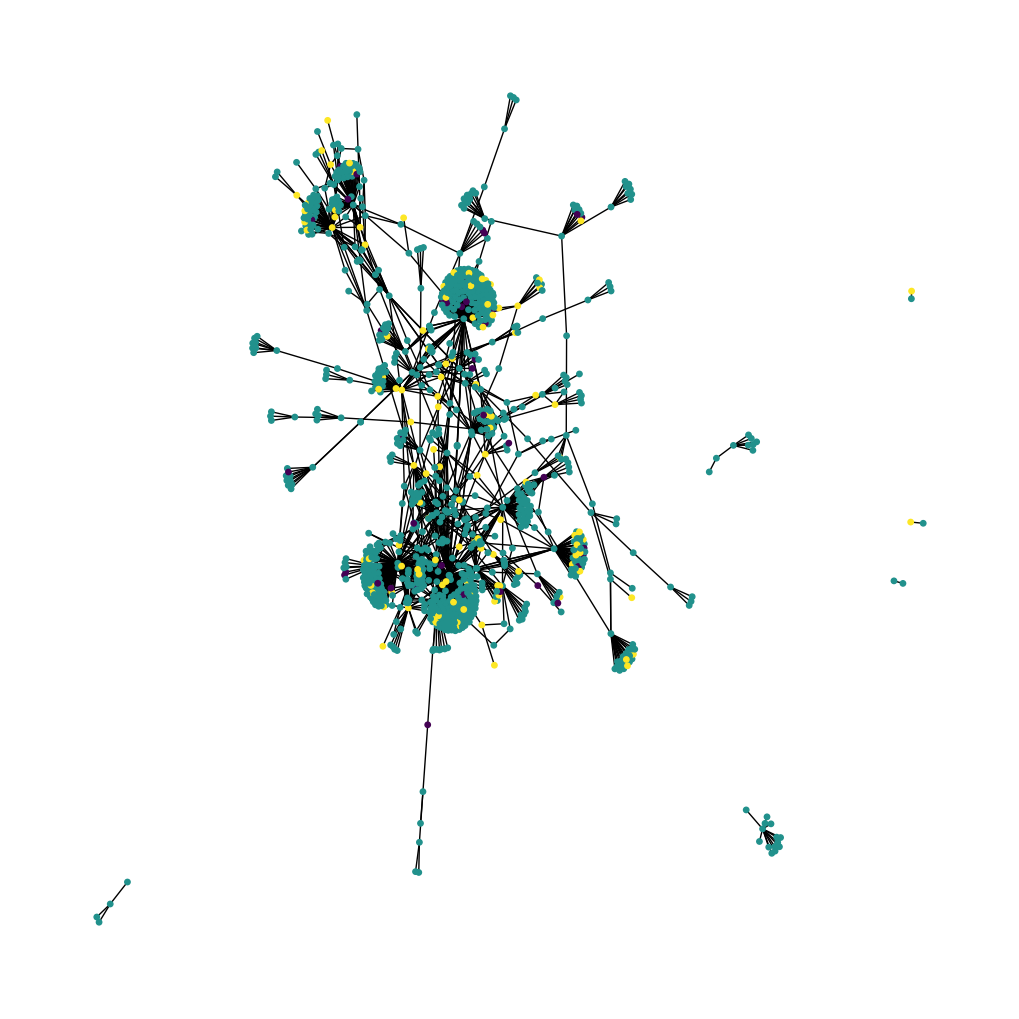

In [26]:
plt.figure(figsize=(10, 10))
colors = node2vec_cc["label"].tolist()
cora_graph = nx.from_pandas_edgelist(graph.sample(n=1500))
subjects = list(node2vec_cc[node2vec_cc["Node_id"].isin(list(cora_graph.nodes))]["label"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [29]:
train_data, test_data = [], []

for _, group_data in node2vec_cc.groupby("label"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.7
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (2147, 130)
Test data shape: (845, 130)


In [30]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [31]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [32]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

In [33]:
feature_names = set(node2vec_cc.columns) - {"Node_id", "label"}
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["label"]
y_test = test_data["label"]

<ipython-input-33-dc99dc6aeccb>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train = train_data[feature_names].to_numpy()
<ipython-input-33-dc99dc6aeccb>:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_test = test_data[feature_names].to_numpy()


array([ 395, 2569,  142, ..., 2498, 2330, 1988])

In [34]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = graph[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].

# node2vec_cc[feature_names] = node2vec_cc[feature_names].apply(lambda x: pd.to_numeric(x, errors='coerce'))


# node_features = tf.cast(
#     node2vec_cc.sort_values("Node_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
# )

node_features = tf.cast(
    node2vec_cc.sort_values('Node_id')[column_names].apply(pd.to_numeric).to_numpy(), dtype=tf.dtypes.float32
)

# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 1589)
Nodes shape: (2992, 128)


In [35]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


In [36]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [38]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [39]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

GNN output shape: tf.Tensor(
[[-0.0313892  -0.05068944  0.0955847 ]
 [ 0.05121787  0.02743888 -0.04885727]
 [ 0.04670675  0.0298567  -0.05238933]], shape=(3, 3), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (2992, 32)                5824      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (2992, 32)                2368      
                                                                 
 logits (Den

In [40]:
x_train = train_data.Node_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/300
8/8 [==============================] - 6s 167ms/step - loss: 0.9408 - acc: 0.6250 - val_loss: 0.7491 - val_acc: 0.8576
Epoch 2/300
8/8 [==============================] - 1s 75ms/step - loss: 0.5407 - acc: 0.8755 - val_loss: 0.5932 - val_acc: 0.8576
Epoch 3/300
8/8 [==============================] - 1s 75ms/step - loss: 0.5460 - acc: 0.8750 - val_loss: 0.6313 - val_acc: 0.8576
Epoch 4/300
8/8 [==============================] - 1s 71ms/step - loss: 0.4957 - acc: 0.8717 - val_loss: 0.6117 - val_acc: 0.8576
Epoch 5/300
8/8 [==============================] - 1s 76ms/step - loss: 0.4818 - acc: 0.8728 - val_loss: 0.5481 - val_acc: 0.8576
Epoch 6/300
8/8 [==============================] - 1s 69ms/step - loss: 0.4938 - acc: 0.8739 - val_loss: 0.5076 - val_acc: 0.8576
Epoch 7/300
8/8 [==============================] - 1s 75ms/step - loss: 0.4734 - acc: 0.8728 - val_loss: 0.4972 - val_acc: 0.8576
Epoch 8/300
8/8 [==============================] - 1s 111ms/step - loss: 0.4775 - acc: 0.

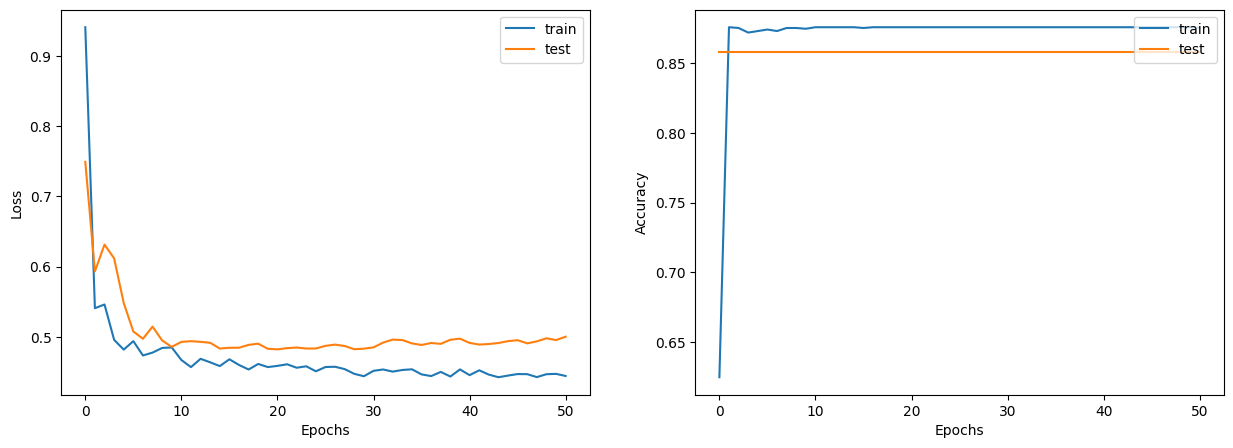

In [41]:
display_learning_curves(history)

In [42]:
x_test = test_data.Node_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 88.52%


In [47]:
from matplotlib import pyplot as plt
import math
# Testing
def test_fun(full_model,x_test,y_test):
    # X_test_new, Y_test_new = final_model(file)
    # print(X_test_new.shape, Y_test_new.shape)
    # Y_test_new = np.array(Y_test_new).astype(None)
    #k_labels = np.array(k_labels).astype(None)
    fmax, tmax = 0.0, 0.0
    precisions, recalls = [], []
    for t in range(1, 101, 1):
        test_preds = full_model.predict(x=x_test)
        #test_preds = full_model.predict(x = [seq_test_data])
        threshold = t / 100.0
        if(threshold == 1.0):
            threshold = 0.99
        print("THRESHOLD IS =====> ", threshold)
        # print(test_preds.shape)
        
        
        test_preds[test_preds>=threshold] = int(1)
        test_preds[test_preds<threshold] = int(0)
        # print(test_preds.shape)
        # print(k_labels.shape)
        rec = recall(y_test, test_preds)

        pre = precision(y_test, test_preds)
        
        recalls.append(rec)
        
        precisions.append(pre)
        # if(pre > 80):
        #   break
        f1 = f_score(y_test, test_preds)*100
        f = 2 * pre * rec / (pre + rec)
        if math.isnan(f):
          f = 0.0
        print('Recall: {0}'.format(rec*100), '     Precision: {0}'.format(pre*100),
              '     F1-score1: {0}'.format(f*100), '      F1-score2: {0}'.format(f1))

        if fmax < f:
            fmax = f
            tmax = threshold
    
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    sorted_index = np.argsort(recalls)
    recalls = recalls[sorted_index]
    precisions = precisions[sorted_index]
    aupr = np.trapz(precisions, recalls)
    print(f'AUPR: {aupr:0.3f}')

    plt.figure()
    plt.plot(recalls, precisions, color='darkorange', lw=2, label=f'AUPR curve (area = {aupr:0.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Area Under the Precision-Recall curve')
    plt.legend(loc="upper right")
    plt.savefig(f'aupr.pdf')

    return tmax
# print("*****************************************GCC EVALUATION******************************************")
# th_set_GCC = test_fun(gnn_model,x_test,y_test)
# print(th_set_GCC)

# th_set_only_LSTM = test_fun(LSTM_model,test_seq_cc,test_label_cc)


# print(th_set_only_LSTM)

In [48]:
import numpy as np
import datetime

def accuracy(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true), ', set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def precision(y_true, y_pred, normalize=True, sample_weight=None):
    pre_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_prec = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_prec = 1
            pre_list.append(tmp_prec)
        elif len(set_pred) > 0:
            tmp_prec = len(set_true.intersection(set_pred))/\
                    float(len(set_pred))
            pre_list.append(tmp_prec)
        else:
            None
    return np.mean(pre_list)

# def recall(y_true, y_pred, normalize=True, sample_weight=None):
#     rec_list = []
#     for i in range(y_true.shape[0]):
#         set_true = set( np.where(y_true[i])[0] )
#         set_pred = set( np.where(y_pred[i])[0] )
#         tmp_rec = None
#         if len(set_true) == 0 and len(set_pred) == 0:
#             tmp_rec = 1
#         else:
#             tmp_rec = len(set_true.intersection(set_pred))/\
#                     float(len(set_true))
#         rec_list.append(tmp_rec)
#     return np.mean(rec_list)

def recall(y_true, y_pred, normalize=True, sample_weight=None):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=1)
    
    rec_list = []
    
    for i in range(possible_positives.shape[0]):
        set_true = set(np.where(y_true[i])[0])
        set_pred = set(np.where(y_pred[i] >= 0.5)[0])
        
        if len(set_true) == 0:
            tmp_rec = 0
        else:
            tmp_rec = len(set_true.intersection(set_pred))/float(len(set_true))
        
        rec_list.append(tmp_rec)
    
    if normalize:
        return np.mean(rec_list)
    else:
        return np.sum(true_positives) / (np.sum(possible_positives) + K.epsilon())


def f_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = (2*len(set_true.intersection(set_pred)))/\
                    float( len(set_true) + len(set_pred))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [49]:
from keras.utils import to_categorical
# convert to one-hot encoded format
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)



*****************************************GCC EVALUATION******************************************
27/27 [==============================] - 1s 21ms/step
THRESHOLD IS =====>  0.01
Recall: 88.52071005917159      Precision: 88.10650887573964      F1-score1: 88.31312380442647       F1-score2: 88.24457593688363
27/27 [==============================] - 1s 22ms/step
THRESHOLD IS =====>  0.02
Recall: 88.52071005917159      Precision: 88.22485207100593      F1-score1: 88.37253344373944       F1-score2: 88.32347140039447
27/27 [==============================] - 1s 17ms/step
THRESHOLD IS =====>  0.03
Recall: 88.52071005917159      Precision: 88.22485207100593      F1-score1: 88.37253344373944       F1-score2: 88.32347140039447
27/27 [==============================] - 1s 27ms/step
THRESHOLD IS =====>  0.04
Recall: 88.52071005917159      Precision: 88.22485207100593      F1-score1: 88.37253344373944       F1-score2: 88.32347140039447
27/27 [==============================] - 1s 23ms/step
THRESHOLD IS

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


27/27 [==============================] - 0s 12ms/step
THRESHOLD IS =====>  0.97
Recall: 0.0      Precision: nan      F1-score1: 0.0       F1-score2: 0.0
27/27 [==============================] - 0s 12ms/step
THRESHOLD IS =====>  0.98
Recall: 0.0      Precision: nan      F1-score1: 0.0       F1-score2: 0.0
27/27 [==============================] - 0s 12ms/step
THRESHOLD IS =====>  0.99
Recall: 0.0      Precision: nan      F1-score1: 0.0       F1-score2: 0.0
27/27 [==============================] - 0s 13ms/step
THRESHOLD IS =====>  0.99
Recall: 0.0      Precision: nan      F1-score1: 0.0       F1-score2: 0.0
AUPR: nan
0.13


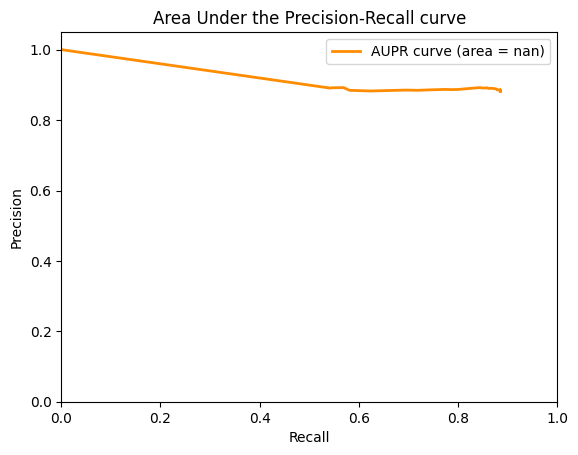

In [50]:
print("*****************************************GCC EVALUATION******************************************")
th_set_GCC = test_fun(gnn_model,x_test,y_test_onehot)
print(th_set_GCC)

In [60]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score


# generate node2vec embeddings
node2vec = Node2Vec(G, dimensions=128, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1)

# create a dictionary of node embeddings
embeddings = {str(node): model.wv[str(node)] for node in G.nodes()}

# create a dataframe of embeddings and labels
df = pd.DataFrame.from_dict(embeddings, orient='index')
df = df.merge(graph_data[['node', 'label']], left_index=True, right_on='node')

# split the data for training and testing
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train logistic regression model
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# evaluate the model
acc_lr = round(accuracy_score(y_test, y_pred_lr) * 100, 2)
pre_score_lr = round(precision_score(y_test, y_pred_lr, average='weighted', zero_division=1) * 100, 2)
print(f'Accuracy: {acc_lr}%')
print(f'Precision Score: {pre_score_lr}%')


In [92]:
X =np.array(dataset['embeddings'].values)

In [90]:

# Split data for train and test
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)


In [91]:
SGDclf = SGDClassifier()
SGDclf.fit(X_train, y_train)
y_pred_sgd = SGDclf.predict(X_test)
acc_sgd = round(accuracy_score(y_test, y_pred_sgd) * 100,2)
pre_score_sgd = round(precision_score(y_test, y_pred_sgd, average='weighted', zero_division=1) * 100,2)
recall_score_sgd = round(recall_score(y_test, y_pred_sgd, average='weighted') * 100,2)
fl_score_sgd = round(f1_score(y_test, y_pred_sgd, average='weighted') * 100,2)
print(acc_sgd)
print(pre_score_sgd)
print(recall_score_sgd)
print(fl_score_sgd)

ValueError: ignored